What's been done here?
1. Clean Hippie list, removed 0 val PPIs and _'_HUMAN_ part.
2. Get the intersection list of genes between HIPPIE & GTEX & shortlist the hippie interactions limited to those genes.
3. Added TF & Kinase information for each of the genes.
4. Generated tissue level diffusion params and then overal network params

(code refered from - http://localhost:4321/notebooks/azure-backup-notebooks/GTF_Project_v1/GTF_N1.8.ipynb)

End product - Looks like below - Available at 

/scratch1/gowthami/GTF/GTF_Project_v2/data/network_generated_data/all_tissue_gene_graph_params_df.p
/scratch1/gowthami/GTF/GTF_Project_v2/data/network_generated_data/all_tissue_network_df.p


What more needs to be done?

1. Have to add mean neighbor zscore and breadth - refer below file

http://localhost:4321/notebooks/azure-backup-notebooks/min_gene_analysis/Min_gene_N10.ipynb

In [34]:
all_tissue_gene_graph_params_df.head(4)

,Centrality_coeff,Clustering_coeff,Gene,IsKinase,IsTF,NeighborList,NumOfKinaseNbs,NumOfNeighbors,NumOfTFNeighbors,Tissue
0,0.003435,0.100000,GRB7,0,0,"[ERBB2, KIT, ERBB3, GRB2, RND1, SHC1, INSR, RE...",4,22,1,Pituitary
1,0.024200,0.047128,ERBB2,0,0,"[GRB7, PAK1, DLG4, TOB1, MUC4, PICK1, GRB2, TG...",19,155,10,Pituitary
2,0.011866,0.055535,PAK1,1,0,"[ERBB2, PLCG1, NCK1, LIMK1, PAK1, HGS, NCK2, P...",11,76,10,Pituitary
3,0.010304,0.062004,DLG4,0,0,"[ERBB2, LYN, PTPRG, LRP1, ACTN2, DLG3, NLGN3, ...",3,66,3,Pituitary


In [35]:
all_tissue_network_df.head(4)

,Gene1,Gene2,PPI_val,Ratio_val,Gene1_ratio,Gene2_ratio,Tissue
0,GRB7,ERBB2,0.90,0.918033,1.000000,0.918033,Pituitary
1,PAK1,ERBB2,0.73,0.918033,1.000000,0.918033,Pituitary
2,DLG4,ERBB2,0.87,0.918033,1.000000,0.918033,Pituitary
3,TOB1,ERBB2,0.55,0.885246,0.967213,0.918033,Pituitary


In [1]:
import pandas as pd
import csv
import numpy as np
import scipy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=40,20
import matplotlib.mlab as mlab
from IPython.display import display
pd.options.display.max_columns = None
from numpy import random
from statsmodels import robust
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import itertools
import networkx as nx
import datetime


In [3]:
gt_exp_dict = pickle.load( 
    open( "./data_generated/g_t_exp_dict.p", "rb" ) )
gt_param_df = pickle.load( 
    open( "./data_generated/gt_exp_param_df.p", "rb" ) )
gene_lookup_dict = pickle.load( 
    open( "./data_generated/gname2ens_lookup.p", "rb" ) )

In [4]:
gtex_genes = set(gt_param_df['Gene'].tolist())
hippie = pd.read_csv('./data/hippie_cleaned.tsv',
                     sep = '\t')

hippie = hippie[(hippie['Gene1_Ensmblid'].isin(gtex_genes))&(hippie['Gene2_Ensmblid'].isin(gtex_genes))]
hippie = hippie[['Gene1_Ensmblid','Gene2_Ensmblid','PPI_val']]
hippie = hippie.rename(columns={"Gene1_Ensmblid": "Gene1", "Gene2_Ensmblid": "Gene2"})
print(hippie.shape)
hippie.head(2)

(374108, 3)


,Gene1,Gene2,PPI_val
0,ENSG00000165092,ENSG00000165092,0.76
1,ENSG00000135424,ENSG00000138435,0.73


In [8]:
len(list(set(hippie['Gene1'].tolist()) | set(hippie['Gene2'].tolist())))

16573

In [4]:
tf_human  = pd.read_csv('/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data/trrust_rawdata.human.tsv',
                        sep='\t',header=None,
                        names = ['TF','Target','ModeofRegulation','PMID'])
tf_human_list = tf_human['TF'].drop_duplicates().tolist()
tf_human_list = list(map(gene_lookup_dict.get, tf_human_list))
tf_human_list = [x for x in tf_human_list if str(x) != 'None']

# http://www.kinase.com/human/kinome/
kinase_list = pd.read_csv('/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v3/data/Kincat_Hsap.08.02.csv',index_col=0)
kinase_list = list(kinase_list.index)
kinase_list = list(map(gene_lookup_dict.get, kinase_list))
kinase_list = [x for x in kinase_list if str(x) != 'None']

In [5]:
print(datetime.datetime.now())
genes = np.char.array(gt_param_df['Gene'].tolist())
tissues = np.char.array(gt_param_df['Tissue'].tolist())
medians = gt_param_df['MedianExp'].tolist()

gt = genes+'_'+ tissues
median_threshold_dict = dict(zip(gt,medians))
print(datetime.datetime.now())


2020-03-14 21:59:33.454641
2020-03-14 21:59:39.111094


In [6]:
def tissue_network(tissue_name, expression_dict ,ppi_network = hippie,
                   threshold_dict = median_threshold_dict,
                   edge_percentage_threshold = 0.25):
    tissue = tissue_name
    ratio_val = []
    print(datetime.datetime.now())
#     count = 0 
    w_dict = {}
    gene_list = set(hippie['Gene1'].tolist()) | set(hippie['Gene2'].tolist())  
    for gene in gene_list:
        gt = gene+'_' + tissue
        w_dict[gt] = np.array(np.array(gt_exp_dict[gt] ) > threshold_dict[gt],dtype=int) 
    print('Arrays done')    
    for index,row in ppi_network.iterrows():
#         count+=1
        g1 = row['Gene1'] +'_' + tissue
        g2 = row['Gene2'] + '_' + tissue
        w1 = w_dict[g1]
        w2 = w_dict[g2]
        both = np.multiply(w1,w2)
        ratio = sum(both)/len(both)
        ratio_val.append(ratio)
        
#         if count%100000 == 0:
#             print(count)
#             print(datetime.datetime.now())
    print('Ratios done')
    print(datetime.datetime.now())
    tissue_network_df = ppi_network.copy()
    tissue_network_df['Ratio_val'] = ratio_val
    tissue_network_df['Tissue'] = tissue
    tissue_network_df_postthreshold = tissue_network_df[tissue_network_df['Ratio_val'] >= edge_percentage_threshold]

    return tissue_network_df_postthreshold

In [7]:
# Clustering is based on this - https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering
#
def iftf_func(gene, tf_list = tf_human_list):
    if gene in tf_list:
        return 1
    else:
        return 0
    
def ifkinase_func(gene, kinase_list = kinase_list):
    if gene in kinase_list:
        return 1
    else:
        return 0
    
def tissue_graph_param_function(tissue, tissue_sample_df, 
                                ratio_val_threshold = 0.25, tf_list = tf_human_list,kinase_list = kinase_list):
    G = nx.from_pandas_edgelist(tissue_sample_df, 'Gene1', 'Gene2', 'PPI_val')
    print('G done')
    print(datetime.datetime.now())

    clustering_dict = nx.clustering(G)
    print('clustering done')
    print(datetime.datetime.now())
    gene_list = list(clustering_dict.keys())
    print(len(gene_list))
    gene = []
    neighbors = []
    is_tf = []
    is_kinase = []
    tf_neighbors = []
    kinase_neighbors = []
    neighbor_list = []
    count = 0
    for g in gene_list:
        count+=1
        gene.append(g)
        neighbors.append(G.degree(g))
        is_tf.append(iftf_func(g))
        is_kinase.append(ifkinase_func(g))
        tf_connections = len(set(tf_list) & set(list(G.neighbors(g))))
        kin_connections = len(set(kinase_list) & set(list(G.neighbors(g))))
        tf_neighbors.append(tf_connections)
        kinase_neighbors.append(kin_connections)
        neighbor_list.append(list(G.neighbors(g)))

        if count%5000 ==0:
            print(count)
            print(datetime.datetime.now())
            
    tissue_gene_graph_params = pd.DataFrame({'Gene':gene,'NumOfNeighbors':neighbors,
                                            'IsTF':is_tf,'NumOfTFNeighbors':tf_neighbors,
                                             'IsKinase':is_kinase,'NumOfKinaseNbs':kinase_neighbors,
                                            'NeighborList':neighbor_list})
        
    tissue_gene_graph_params['Clustering_coeff']= tissue_gene_graph_params['Gene'].map(clustering_dict)
    tissue_gene_graph_params['Tissue'] = tissue
    
    return tissue_gene_graph_params

In [9]:
tissue_list = list(set(gt_param_df['Tissue'].tolist()))
# tissue_list = ['Heart']
all_tissue_network_df = pd.DataFrame(columns = ['Gene1', 'Gene2', 'PPI_val', 'Ratio_val', 
                                                'Gene1_ratio', 'Gene2_ratio','Tissue'])

all_tissue_gene_graph_params_df = pd.DataFrame(columns = ['Gene', 'IsTF', 'NumOfNeighbors', 'NumOfTFNeighbors',
       'Clustering_coeff','Tissue','IsKinase','NumOfKinaseNbs','NeighborList'])
for tissue in tissue_list:
    print(tissue)
    print(datetime.datetime.now())
    tissue_df = tissue_network(tissue,gt_exp_dict)
    print(tissue_df.shape)
    name = './data_generated/network_generated/'+ tissue + '_network.p'
    print(name)
    pickle.dump( tissue_df, open( name , "wb" ) )
    tissue_gene_graph_params = tissue_graph_param_function(tissue,tissue_df)    
    all_tissue_network_df = all_tissue_network_df.append(tissue_df,ignore_index=True)
    all_tissue_gene_graph_params_df = all_tissue_gene_graph_params_df.append(
        tissue_gene_graph_params,ignore_index=True)
    
pickle.dump( all_tissue_network_df, 
            open( './data_generated/network_generated/all_tissue_network.p' , "wb" ) )
pickle.dump( all_tissue_gene_graph_params_df,
            open( './data_generated/network_generated/gt_graph_param_df.p' , "wb" ) )
print('gt_graph_param_df pickled')

Small Intestine
2020-03-14 22:01:15.323975
2020-03-14 22:01:15.324072
Arrays done
Ratios done
2020-03-14 22:04:46.885809
(279998, 5)
./data_generated/network_generated/Small Intestine_network.p
G done
2020-03-14 22:04:53.061344
clustering done
2020-03-14 22:05:24.587738
15223
5000
2020-03-14 22:05:25.738612
10000
2020-03-14 22:05:26.754176
15000
2020-03-14 22:05:27.765674


/fs/cbcb-scratch/gowthami/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Adipose Tissue
2020-03-14 22:05:28.275669
2020-03-14 22:05:28.275743
Arrays done
Ratios done
2020-03-14 22:12:17.821312
(290023, 5)
./data_generated/network_generated/Adipose Tissue_network.p
G done
2020-03-14 22:12:24.152221
clustering done
2020-03-14 22:12:56.130718
15222
5000
2020-03-14 22:12:57.260948
10000
2020-03-14 22:12:58.281855
15000
2020-03-14 22:12:59.272587
Muscle
2020-03-14 22:12:59.869854
2020-03-14 22:12:59.869936
Arrays done
Ratios done
2020-03-14 22:18:34.339777
(298008, 5)
./data_generated/network_generated/Muscle_network.p
G done
2020-03-14 22:18:40.677496
clustering done
2020-03-14 22:19:15.310056
14924
5000
2020-03-14 22:19:16.477381
10000
2020-03-14 22:19:17.504072
Fallopian Tube
2020-03-14 22:19:19.311740
2020-03-14 22:19:19.311827
Arrays done
Ratios done
2020-03-14 22:22:11.665145
(87259, 5)
./data_generated/network_generated/Fallopian Tube_network.p
G done
2020-03-14 22:22:13.847641
clustering done
2020-03-14 22:22:18.359352
13526
5000
2020-03-14 22:22:19.3514

In [11]:
tissue_df.head()

,Gene1,Gene2,PPI_val,Ratio_val,Tissue
0,ENSG00000165092,ENSG00000165092,0.76,0.499419,Heart
1,ENSG00000135424,ENSG00000138435,0.73,0.343786,Heart
2,ENSG00000158528,ENSG00000184009,0.65,0.284553,Heart
3,ENSG00000122862,ENSG00000026508,0.63,0.390244,Heart
4,ENSG00000141738,ENSG00000141736,0.90,0.342625,Heart


In [13]:
tissue_df[tissue_df['Ratio_val']<0.25]

,Gene1,Gene2,PPI_val,Ratio_val,Tissue
67,ENSG00000164078,ENSG00000176105,0.55,0.249710,Heart
86,ENSG00000108854,ENSG00000178826,0.63,0.245064,Heart
99,ENSG00000101665,ENSG00000129152,0.63,0.218351,Heart
114,ENSG00000105198,ENSG00000184009,0.52,0.019744,Heart
130,ENSG00000185338,ENSG00000157404,0.77,0.236934,Heart
...,...,...,...,...,...
406064,ENSG00000184357,ENSG00000072571,0.63,0.182346,Heart
406072,ENSG00000124610,ENSG00000083642,0.63,0.163763,Heart
406073,ENSG00000184357,ENSG00000119541,0.63,0.180023,Heart
406089,ENSG00000112038,ENSG00000165915,0.63,0.065041,Heart


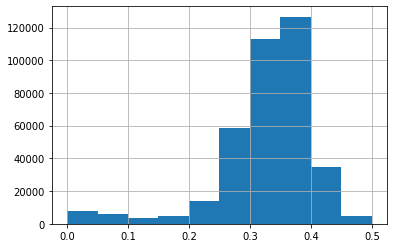

In [12]:
tissue_df['Ratio_val'].hist()

eQTL calculation is in this file
http://localhost:4321/notebooks/azure-backup-notebooks/GTF_Project_v1/GTF_N1.9.ipynb
